In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from sympy import diff,solve
from itertools import count
import math

from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

In [2]:
def full_grid(g_a,g_b,g_L,T,A = 0):
    X, x_a, x_b, x_L, z_a, z_b = sy.symbols('X, x_a, x_b, x_L, z_a, z_b')
    
    def beta_L(A):
        eq1 = (-diff(g_L) + diff(g_b))
        eq2 = (-diff(g_b) + (g_b - g_L)/(x_b - x_L))
        sol = solve((eq1,eq2),[x_b,x_L])
        if 0 <= sol[0][0] <= 1:
            x_b_,x_L_ = sol[0][0],sol[0][1]
        else:
            x_b_,x_L_ = sol[1][0],sol[1][1]
        z_b_ = (X - x_L_)/(x_b_ - x_L_)
        z_L_ = 1 - z_b_
        return z_b_*g_b.subs(x_b, x_b_) + z_L_*g_L.subs(x_L, x_L_)

    def alpha_L(A):
        eq1 = (-diff(g_L) + diff(g_a))
        eq2 = (-diff(g_a) + (g_a - g_L)/(x_a - x_L))
        sol = solve((eq1,eq2),[x_a,x_L])
        if 0 <= sol[0][0] <= 1:
            x_a_,x_L_ = sol[0][0],sol[0][1]
        else:
            x_a_,x_L_ = sol[1][0],sol[1][1]
        x_a_,x_L_ = sol[0][0],sol[0][1]
        z_a_ = (X - x_L_)/(x_a_ - x_L_)
        z_L_ = 1 - z_a_
        return z_a_*g_a.subs(x_a, x_a_) + z_L_*g_L.subs(x_L, x_L_)

    def alpha_beta(A):
        eq1 = (-diff(g_a) + diff(g_b))
        eq2 = (-diff(g_b) + (g_b - g_a + A*(1-2*(x_a-X)/(x_a-x_b)))/(x_b - x_a))
        sol = solve((eq1,eq2),[x_a,x_b])

        x_a_,x_b_ = sol[0][0],sol[0][1]
        z_a_ = (X - x_b_)/(x_a_ - x_b_)
        z_b_ = 1 - z_a_
        return z_a_*g_a.subs(x_a,x_a_) + z_b_*g_b.subs(x_b,x_b_) + A*z_a_*z_b_ 
    
    def alpha_beta_L(A): #Delete out? 
        eq1 = (-diff(g_a) + diff(g_b))
        eq2 = (-diff(g_b) + diff(g_L))
        eq3 = (-diff(g_L) + (g_a - g_L + A*z_b)/(x_a - x_L))
        eq4 = (-diff(g_L) + (g_b - g_L + A*z_a)/(x_b - x_L))
        eq5 = (X - ((1-z_a-z_b)*x_L + z_a*x_a + z_b*x_b))
        sol = solve((eq1,eq2,eq3,eq4,eq5),[x_a,x_b,x_L,z_a,z_b])

        if np.size(sol) == 0:
            return float('inf')
        else:
            x_a_,x_b_,x_L_ = sol[0][0],sol[0][1],sol[0][2]
            z_a_,z_b_ = sol[0][3],sol[0][4]
            z_L_ = 1-z_a_-z_b_
        return z_a_*g_a.subs(x_a,x_a_) + z_b_*g_b.subs(x_b,x_b_) + z_L_*g_L.subs(x_L,x_L_) + A*z_a_*z_b_
    
#input the common tangent and 2 free energy functions
#returns the feasible boundaries    
    def inter_tan_G(com_tan,g_1,g_2,x_1,x_2):
        eq1 = (com_tan - g_1.subs(x_1,X))
        sol_1 = solve((eq1),[X])
        eq2 = (com_tan - g_2.subs(x_2,X))
        sol_2 = solve((eq2),[X])
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])

#Create new common tangents that obey the feasible boundaries
# and are infinity elsewhere
    def correct_tangent(com_tan,intersection_G):
        new_tangent = sy.Piecewise(
            (float('inf'),X <= min(intersection_G) -1e-8), #account for some error
            (float('inf'),X >= max(intersection_G)+1e-8),
            (com_tan,True))
        return new_tangent
    
#Find the boundaries which the common tangents intersect
    def intersect_com_tans(com_tan_1,com_tan_2):
        eq1 = (com_tan_1 - com_tan_2)
        sol = np.array(solve((eq1),[X]))
        return sol[np.where((sol > 0)&(sol < 1))]

    def intersect_abl(com_abl,com_al,com_bl): #delete out? 
        eq1 = (com_abl - com_al)
        sol_1 = solve((eq1),[X])
        if np.size(sol_1) == 0:
            sol_1 = [float('inf')]
        eq2 = (com_abl - com_bl)
        sol_2 = solve((eq2),[X])
        if np.size(sol_2) == 0:
            sol_2 = [float('inf')]
        return np.array([sy.re(sol_1[0]), sy.re(sol_2[0])])
    
    def correct_tangent_abl(com_tan,intersect_abl,al_G,bl_G):
        if min(al_G) <= intersect_abl[0] <= max(al_G):
            new_tangent = sy.Piecewise(
                (float('inf'),X <= min(intersect_abl) -1e-8), #account for some error
                (float('inf'),X >= max(intersect_abl)+1e-8),
                (com_tan,True))
        else:
            new_tangent = sy.Piecewise(
                (float('inf'),X <= 1 ), #account for some error
                (float('inf'),X >= 0))
        return new_tangent
    
    ##Find all of the points where a common tangent touches free energies and crosses other common tangents
    al_G = inter_tan_G(alpha_L(A),g_a,g_L,x_a,x_L)
    bl_G = inter_tan_G(beta_L(A),g_b,g_L,x_b,x_L)
    ab_G = inter_tan_G(alpha_beta(A),g_a,g_b,x_a,x_b)
    com_bl = correct_tangent(beta_L(A),bl_G)
    com_al = correct_tangent(alpha_L(A),al_G)
    com_ab = correct_tangent(alpha_beta(A),ab_G)
    al_bl = intersect_com_tans(com_al,com_bl)
    al_ab = intersect_com_tans(com_al,com_ab)
    ab_bl = intersect_com_tans(com_ab,com_bl)
    #Handle the three phase last
    #First finds the intersections
    abl_al_bl = intersect_abl(alpha_beta_L(A),alpha_L(A),beta_L(A))
    # computes the common tangent in feasible region 
    com_abl = correct_tangent_abl(alpha_beta_L(A),abl_al_bl,al_G,bl_G)
    # #add end points to full grid
    ends = np.array([0,1])
    grid_start = np.sort(np.concatenate((al_G,bl_G,ab_G,al_bl,al_ab,ab_bl,abl_al_bl)))
    grid_start = grid_start[np.where((0 < grid_start)&(1 > grid_start))]
    #create full grid to look (1e-# is to account for the minor errors and equal values at a point)
    grid_x = np.sort(np.concatenate((grid_start,grid_start*(1-1e-6),grid_start*(1+1e-6),ends)))

    ##Takes in the points and checks the phases of each point
    def check_phase(grid_x):
        phases = np.array(['αL','βL','αβ','αβL','α','β','L'])
        exit = []
        G_L = sy.lambdify(x_L,g_L)
        G_a = sy.lambdify(x_a,g_a)
        G_b = sy.lambdify(x_b,g_b)
        al_tangent = sy.lambdify(X,com_al)
        bl_tangent = sy.lambdify(X,com_bl)
        ab_tangent = sy.lambdify(X,com_ab)
        abl_tangent = sy.lambdify(X,com_abl)
        for i,val in enumerate(grid_x):
            L = G_L(val)
            a = G_a(val)
            b = G_b(val)
            al = al_tangent(val)
            bl = bl_tangent(val)
            ab = ab_tangent(val)
            abl = abl_tangent(val)
            check = np.array([al,bl,ab,abl,a,b,L])
            index = np.argmin(check)
            exit.append(phases[index])
        exit = np.array(exit)

        exit = exit[grid_x>=0]    
        grid_x = grid_x[grid_x>=0] ## NOT SURE IF WE CAN DO THIS SIMPLY LIKE THIS. 

        res = {}
        for ph in phases: 
            idx = exit == ph
            if idx.any():
                res[ph] = {'c':[np.min(grid_x[idx]),np.max(grid_x[idx])]}
#         res_all.append(res)
        
        return res
    
    return check_phase(grid_x), sy.lambdify(X,com_al),sy.lambdify(X,com_bl), sy.lambdify(X,com_ab), sy.lambdify(X,com_abl)

In [3]:
## Take input from full_grid and place into here with correct phases
def organize_phases(phases,grid,T_grid):
    pd = {}
    patches = []
    for ph in phases: 
        pd[ph] = []
        for ii,res in enumerate(grid): 
            if ph in res.keys():
                pd[ph].append([res[ph]['c'][0],T_grid[ii]])
                pd[ph].append([res[ph]['c'][1],T_grid[ii]])
    return pd

In [4]:
##points in the form of the output from organize_phases
def plot_diagram(phases,points,title = 'Phase plot',xlabel = 'B Fraction',ylabel = 'Temp'):
    import math
    import matplotlib.patches as patches
    import pylab

    for ph in phases: 
        pp = points[ph]
        if len(pp) > 0:
            cent=(sum([p[0] for p in pp])/len(pp),sum([p[1] for p in pp])/len(pp))
            # sort by polar angle
            pp.sort(key=lambda p: math.atan2(p[1]-cent[1],p[0]-cent[0]))
            # plot points
            pylab.scatter([p[0] for p in pp],[p[1] for p in pp],label = str(ph))
            # plot polyline
            pylab.gca().add_patch(patches.Polygon(pp,closed=True,fill=False)) 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(title)
    plt.show()

In [72]:
x_a, x_b, x_L = sy.symbols('x_a, x_b, x_L')
phases = np.array(['αL','βL','αβ','αβL','α','β','L'])

x_a0,x_L0,x_b0 = .2,.5,.8
b_a,b_L,b_b = 10,12,11
a = 40
T_grid = np.sort(np.concatenate((np.linspace(1,1.1,3),np.linspace(1.46,1.56,5),np.linspace(1,2.4,8))))
# T_grid = np.linspace(1,3,10)
res_all = []
g_a = a*(x_a-x_a0)**2 + b_a
g_b = a*(x_b-x_b0)**2 + b_b
for i in range(len(T_grid)):
    T = T_grid[i]
    g_L = a*(x_L-x_L0)**2 + b_L - T
    res_all.append(full_grid(g_a,g_b,g_L,T,A = 4)[0])

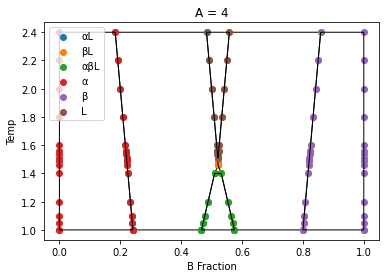

In [73]:
phase_dict = organize_phases(phases,res_all,T_grid)
plot_diagram(phases,phase_dict,title = 'A = 4')

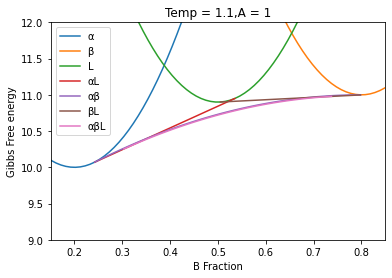

In [62]:
T = T_grid[3]
g_L = a*(x_L-x_L0)**2 + b_L - T
tangents = full_grid(g_a,g_b,g_L,T,A = 1)
al_tangent,bl_tangent,ab_tangent,abl_tangent = tangents[1],tangents[2],tangents[3],tangents[4]

g_a_plot = lambda x_a: a*(x_a-x_a0)**2 + b_a
g_b_plot = lambda x_b: a*(x_b-x_b0)**2 + b_b
g_L_plot = lambda x_L: a*(x_L-x_L0)**2 + b_L - T
x_grid = np.linspace(0,1,100)
plt.plot(x_grid, g_a_plot(x_grid),label = 'α')
plt.plot(x_grid, g_b_plot(x_grid), label = 'β')
plt.plot(x_grid, g_L_plot(x_grid), label = 'L')
plt.plot(x_grid, al_tangent(x_grid), label = 'αL')
plt.plot(x_grid, ab_tangent(x_grid), label = 'αβ')
plt.plot(x_grid, bl_tangent(x_grid), label = 'βL')
plt.plot(x_grid, abl_tangent(x_grid), label = 'αβL')
plt.title('Temp = ' + str(T) + ',A = 1' )
plt.xlabel('B Fraction')
plt.ylabel('Gibbs Free energy')
plt.ylim(9,12)
plt.xlim(0.15,0.85)
plt.legend()
plt.savefig('free_energy T = ' + str(int(T*10)) + 'A = 1')
plt.show()

In [309]:
def beta_L(A):
    eq1 = (-diff(g_L) + diff(g_b))
    eq2 = (-diff(g_b) + (g_b - g_L)/(x_b - x_L))
    sol = solve((eq1,eq2),[x_b,x_L])
    if 0 <= sol[0][0] <= 1:
        x_b_,x_L_ = sol[0][0],sol[0][1]
    else:
        x_b_,x_L_ = sol[1][0],sol[1][1]
    z_b_ = (X - x_L_)/(x_b_ - x_L_)
    z_L_ = 1 - z_b_
    z_a_ = 0
    return (z_a_,z_b_,z_L_)


def alpha_L(A):
    eq1 = (-diff(g_L) + diff(g_a))
    eq2 = (-diff(g_a) + (g_a - g_L)/(x_a - x_L))
    sol = solve((eq1,eq2),[x_a,x_L])
    if 0 <= sol[0][0] <= 1:
        x_a_,x_L_ = sol[0][0],sol[0][1]
    else:
        x_a_,x_L_ = sol[1][0],sol[1][1]
    x_a_,x_L_ = sol[0][0],sol[0][1]
    z_a_ = (X - x_L_)/(x_a_ - x_L_)
    z_L_ = 1 - z_a_
    z_b_ = 0
    return (z_a_,z_b_,z_L_)

def alpha_beta_L(A): #Delete out? 
    eq1 = (-diff(g_a) + diff(g_b))
    eq2 = (-diff(g_b) + diff(g_L))
    eq3 = (-diff(g_L) + (g_a - g_L + A*z_b)/(x_a - x_L))
    eq4 = (-diff(g_L) + (g_b - g_L + A*z_a)/(x_b - x_L))
    eq5 = (X - ((1-z_a-z_b)*x_L + z_a*x_a + z_b*x_b))
    sol = solve((eq1,eq2,eq3,eq4,eq5),[x_a,x_b,x_L,z_a,z_b])

    if np.size(sol) == 0:
        return float('inf')
    else:
        x_a_,x_b_,x_L_ = sol[0][0],sol[0][1],sol[0][2]
        z_a_,z_b_ = sol[0][3],sol[0][4]
        z_L_ = 1-z_a_-z_b_
    return (z_a_,z_b_,z_L_)

In [344]:
X,x_a, x_b, x_L, z_a, z_b = sy.symbols('X,x_a, x_b, x_L, z_a, z_b')

x_a0,x_L0,x_b0 = .2,.5,.8
b_a,b_L,b_b = 10,12,10.5
a = 50
T = 1.5
# T_grid = np.sort(np.concatenate((np.linspace(1.8,1.82,2),np.linspace(1,3,10))))
# T_grid = np.linspace(1,2.5,10)
res_all = []
g_a = a*(x_a-x_a0)**2 + b_a
g_b = a*(x_b-x_b0)**2 + b_b
g_L = a*(x_L-x_L0)**2 + b_L - T

In [345]:
alpha_L(1)

(1.72222222222222 - 3.33333333333333*X,
 0,
 3.33333333333333*X - 0.722222222222222)

In [346]:
beta_L(1)

(0,
 3.33333333333333*X - 1.66666666666667,
 2.66666666666667 - 3.33333333333333*X)

In [347]:
alpha_beta_L(1) #Liquid amount does not change! 

(1.14705882352941 - 1.76470588235294*X,
 1.76470588235294*X - 0.647058823529412,
 2.22044604925031e-16*X + 0.5)

In [348]:
g_L.subs(x_L,X),g_b.subs(x_b,X),g_a.subs(x_a,X)

(50*(X - 0.5)**2 + 10.5, 50*(X - 0.8)**2 + 10.5, 50*(X - 0.2)**2 + 10)